# Data processing for scan bump hunt (multiple windows)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from helpers.plotting import *
from helpers.physics_functions import *
from helpers.data_transforms import bootstrap_array, logit_transform

plt.style.use("../science.mplstyle")


In [3]:
import yaml
with open("workflow_scan.yaml", "r") as file:
    workflow = yaml.safe_load(file)

In [7]:
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data/"
os.makedirs(processed_data_dir, exist_ok = True)

In [8]:
working_dir = workflow["file_paths"]["working_dir"]
path_to_compiled_data = workflow["file_paths"]["data_storage_dir"]+"/compiled_data/"+workflow["analysis_keywords"]["dataset_id"]
    
codes_list = ["skimmed_data_2016H_30555_nojet"] # may want multiple codes for injection studies


uncut_data_OS, uncut_data_SS = {code:{} for code in codes_list},  {code:{} for code in codes_list}



for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        tmp_dict = pickle.load(ifile)
        for key in tmp_dict.keys():
            if "samesign" in key:
                uncut_data_SS[code][key[:-9]] = tmp_dict[key]
            else:
                uncut_data_OS[code][key] = tmp_dict[key]

    print(code, "opp sign",  uncut_data_OS[code][list(uncut_data_OS[code].keys())[0]].shape)
    print(code, "same sign", uncut_data_SS[code][list(uncut_data_SS[code].keys())[0]].shape)

skimmed_data_2016H_30555_nojet opp sign (21803678,)
skimmed_data_2016H_30555_nojet same sign (6756613,)


In [9]:
feature_set = list(uncut_data_OS[codes_list[0]].keys())
feature_set = [x for x in feature_set if "HLT" not in x]
print(feature_set)

['dimu_pt', 'dimu_eta', 'dimu_phi', 'n_muons', 'n_jets', 'dimu_mass', 'mu0_ip3d', 'mu1_ip3d', 'mu0_jetiso', 'mu1_jetiso', 'mu0_eta', 'mu1_eta', 'mu0_pt', 'mu1_pt', 'mu0_phi', 'mu1_phi', 'mu0_iso04', 'mu1_iso04', 'mumu_deltaR', 'mumu_deltapT']


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

Random seed is used to set aside a portion of the test set

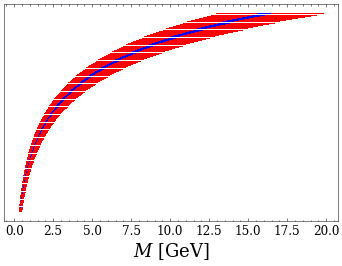

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172])


In [10]:
# define SB / SR choices

detector_resolution = 0.011
start_mass, stop_mass = 0.3, 20 # GeV


current_mass = start_mass
all_bins = [start_mass]


while current_mass < stop_mass:
    loc_bin_width = current_mass*detector_resolution
    current_mass += loc_bin_width
    all_bins.append(current_mass)
    

num_bins_total = len(all_bins)

SB_num_bins = 17
SR_num_bins = 5
window_gap = 2
window_length = 2*SB_num_bins + SR_num_bins


bin_definitions = {}
    
plt.figure()

window_index = 0

for i in range(0, num_bins_total, window_gap):
    if i + window_length < num_bins_total:
        
        bin_definitions[window_index] = {"SBL":[],"SR":[], "SBH":[]}
        
        
        bin_definitions[window_index]["SBL"] = all_bins[i:i+SB_num_bins+1]
        bin_definitions[window_index]["SR"] = all_bins[i+SB_num_bins:i+SB_num_bins+SR_num_bins+1]
        bin_definitions[window_index]["SBH"] = all_bins[i+SB_num_bins+SR_num_bins:i+2*SB_num_bins+SR_num_bins+1]
        
        plt.plot(bin_definitions[window_index]["SBL"], [i for x in bin_definitions[window_index]["SBL"]], color = "red")
        plt.plot(bin_definitions[window_index]["SR"], [i for x in bin_definitions[window_index]["SR"]], color = "blue")
        plt.plot(bin_definitions[window_index]["SBH"], [i for x in bin_definitions[window_index]["SBH"]], color = "red")
        
        window_index += 1

plt.xlabel("$M$ [GeV]")
plt.yticks([])
plt.show()
    
num_windows = len(bin_definitions.keys())
print(bin_definitions.keys())
with open(f"{processed_data_dir}/bin_definitions", "wb") as ofile:
    pickle.dump(bin_definitions, ofile)



In [11]:
cut_data_OS, cut_data_SS = {code:{} for code in codes_list},  {code:{} for code in codes_list}

analysis_cuts_dict = workflow["analysis_keywords"]["analysis_cuts"]

for code in codes_list:

    pass_indices_OS = np.ones((uncut_data_OS[code]["dimu_mass"].shape[0]))
    pass_indices_SS = np.ones((uncut_data_SS[code]["dimu_mass"].shape[0]))
    try:
        a = analysis_cuts_dict["lower"].keys()
        for cut_var in analysis_cuts_dict["lower"].keys():
            pass_indices_OS = np.logical_and(pass_indices_OS, uncut_data_OS[code][cut_var] >= analysis_cuts_dict["lower"][cut_var])
            pass_indices_SS = np.logical_and(pass_indices_SS, uncut_data_SS[code][cut_var] >= analysis_cuts_dict["lower"][cut_var])
    except:
        pass
    try:
        a = analysis_cuts_dict["upper"].keys()
        for cut_var in analysis_cuts_dict["upper"].keys():
            pass_indices_OS = np.logical_and(pass_indices_OS, uncut_data_OS[code][cut_var] <= analysis_cuts_dict["upper"][cut_var])
            pass_indices_SS = np.logical_and(pass_indices_SS, uncut_data_SS[code][cut_var] <= analysis_cuts_dict["upper"][cut_var])
    except:
        pass
        
    pass_indices_OS = np.logical_and(pass_indices_OS, (uncut_data_OS[code]["dimu_mass"] >= start_mass) & (uncut_data_OS[code]["dimu_mass"] <= stop_mass))
    pass_indices_SS = np.logical_and(pass_indices_SS, (uncut_data_SS[code]["dimu_mass"] >= start_mass) & (uncut_data_SS[code]["dimu_mass"] <= stop_mass))


    # apply cuts to oppsign
    for feat in feature_set:
        cut_data_OS[code][feat] = uncut_data_OS[code][feat][pass_indices_OS]
        cut_data_SS[code][feat] = uncut_data_SS[code][feat][pass_indices_SS]
    
    print(f"{code} OS has shape {cut_data_OS[code][feat].shape} after cuts")
    print(f"{code} SS has shape {cut_data_SS[code][feat].shape} after cuts")
    
    

skimmed_data_2016H_30555_nojet OS has shape (88285,) after cuts
skimmed_data_2016H_30555_nojet SS has shape (5488,) after cuts


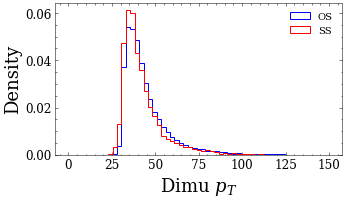

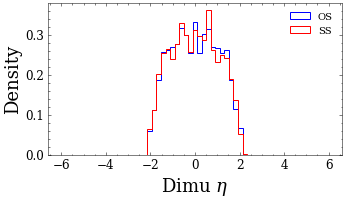

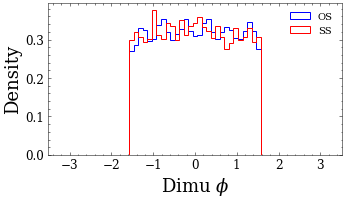

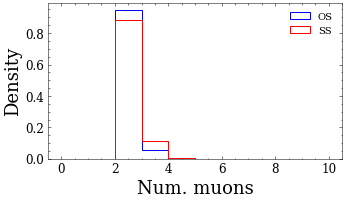

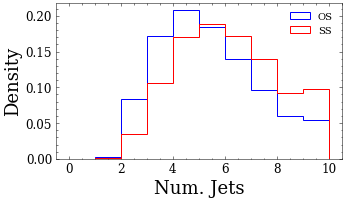

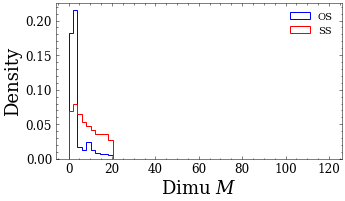

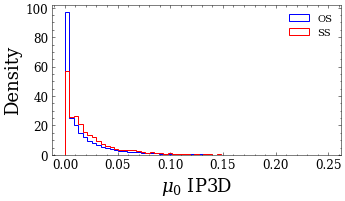

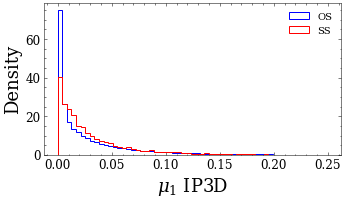

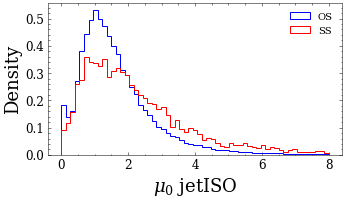

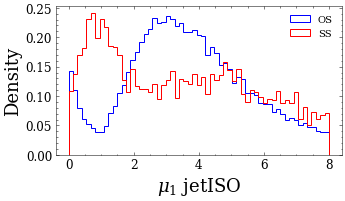

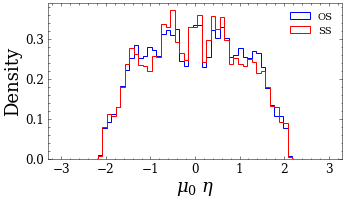

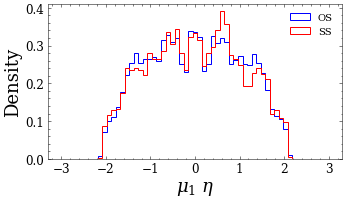

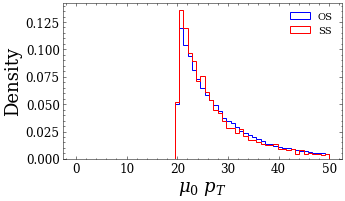

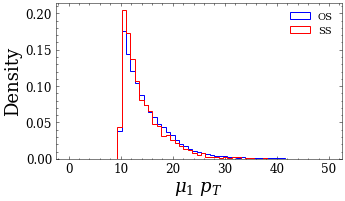

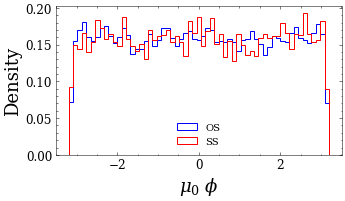

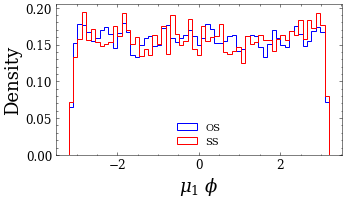

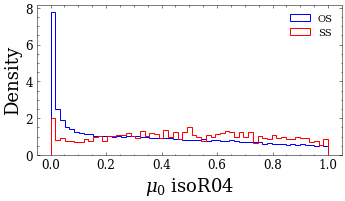

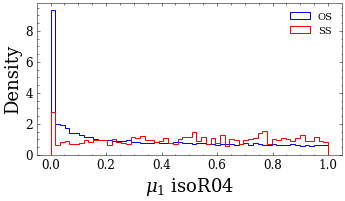

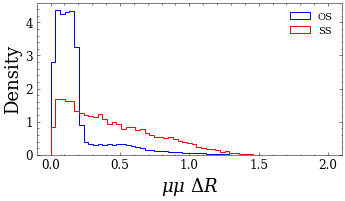

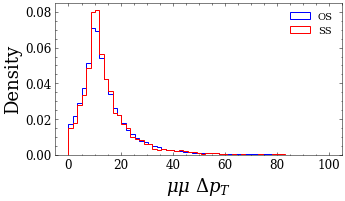

In [9]:
kwargs_dict_dtype = {"OS":{"density": True, "histtype": "step", "color":"blue", "label": "OS"},
                    "SS":{"density": True, "histtype": "step", "color":"red", "label": "SS"}}
        
hist_all_features_dict([cut_data_OS[codes_list[0]], cut_data_SS[codes_list[0]]], ["OS", "SS"], feature_set, kwargs_dict_dtype, nice_labels=True)


Split data into bands

On window 0
SB bounds: 0.3, 0.4596384196509145
SR bounds: 0.3613190833418048, 0.3816336646820012
Total events opp sign: 3440
Total events same sign: 59

On window 1
SB bounds: 0.30663630000000003, 0.4698060811320124
SR bounds: 0.3693118227844088, 0.39007578297843176
Total events opp sign: 3387
Total events same sign: 61

On window 2
SB bounds: 0.31341940159230003, 0.48019866145273365
SR bounds: 0.37748136961622275, 0.39870464937369765
Total events opp sign: 3383
Total events same sign: 61

On window 3
SB bounds: 0.3203525521749233, 0.4908211360427296
SR bounds: 0.3858316349935032, 0.4075243949224932
Total events opp sign: 3348
Total events same sign: 60

On window 4
SB bounds: 0.3274390709815848, 0.5016785903931308
SR bounds: 0.3943666165911945, 0.41653924206257364
Total events opp sign: 3335
Total events same sign: 62

On window 5
SB bounds: 0.33468235067076846, 0.5127762224912172
SR bounds: 0.40309040051680833, 0.42575350663623984
Total events opp sign: 3327
Total events same sign: 6

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)



On window 66
SB bounds: 1.2713753671357455, 1.9479098817779175
SR bounds: 1.531240607456127, 1.6173321351547973
Total events opp sign: 12864
Total events same sign: 303

On window 67
SB bounds: 1.2994994616321554, 1.990999596272727
SR bounds: 1.5651131809336638, 1.6531091393165567
Total events opp sign: 13137
Total events same sign: 326

On window 68
SB bounds: 1.3282456892229202, 2.035042498341876
SR bounds: 1.5997350496090972, 1.6896775665873782
Total events opp sign: 13403
Total events same sign: 329

On window 69
SB bounds: 1.3576278121142205, 2.0800596734476966
SR bounds: 1.6351227886415, 1.7270549240378577
Total events opp sign: 13660
Total events same sign: 336

On window 70
SB bounds: 1.3876598969459992, 2.126072673484033
SR bounds: 1.6712933398490388, 1.7652591060124991
Total events opp sign: 13966
Total events same sign: 354

On window 71
SB bounds: 1.4183563215263417, 2.1731035270941734
SR bounds: 1.7082640198198393, 1.8043084026966016
Total events opp sign: 14233
Total eve

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1

Total events opp sign: 30198
Total events same sign: 551

On window 98
SB bounds: 2.560635431671037, 3.9232214103847083
SR bounds: 3.084021489813086, 3.2574156123439866
Total events opp sign: 29527
Total events same sign: 554

On window 99
SB bounds: 2.6172792480550324, 4.010006991203828
SR bounds: 3.152243129189241, 3.329472903104648
Total events opp sign: 28907
Total events same sign: 558

On window 100
SB bounds: 2.675176082301258, 4.0987123558562475
SR bounds: 3.221973899450036, 3.4031241731942257
Total events opp sign: 28305
Total events same sign: 567

On window 101
SB bounds: 2.734353652417844, 4.189379971880143
SR bounds: 3.2932471840797706, 3.478404683029455
Total events opp sign: 27804
Total events same sign: 573

On window 102
SB bounds: 2.794840289562979, 4.282053246238104
SR bounds: 3.366097105038799, 3.5553504730227496
Total events opp sign: 27270
Total events same sign: 587

On window 103
SB bounds: 2.8566649516084017, 4.376776546098137
SR bounds: 3.4405585390993623, 3.6

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1

Total events opp sign: 22641
Total events same sign: 610

On window 107
SB bounds: 3.1179457262010297, 4.777092153827878
SR bounds: 3.7552443056681786, 3.96637684589894
Total events opp sign: 9837
Total events same sign: 627

On window 108
SB bounds: 3.1869178036103225, 4.882766209362705
SR bounds: 3.838314064953864, 4.05411706810707
Total events opp sign: 5415
Total events same sign: 638

On window 109
SB bounds: 3.2574156123439866, 4.990777880680018
SR bounds: 3.9232214103847083, 4.143798191770666
Total events opp sign: 4942
Total events same sign: 643

On window 110
SB bounds: 3.329472903104648, 5.1011788781785405
SR bounds: 4.010006991203828, 4.2354631515708245
Total events opp sign: 4704
Total events same sign: 643

On window 111
SB bounds: 3.4031241731942257, 5.214022056142729
SR bounds: 4.0987123558562475, 4.329155831946723
Total events opp sign: 4532
Total events same sign: 663

On window 112
SB bounds: 3.478404683029455, 5.329361438046662
SR bounds: 4.189379971880143, 4.424921

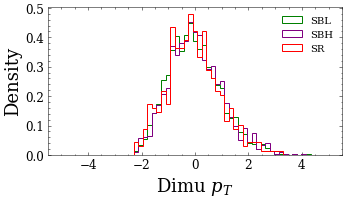

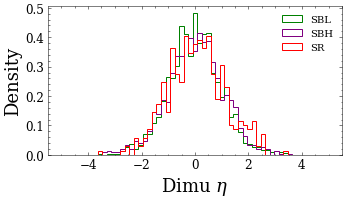

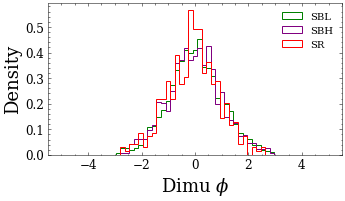

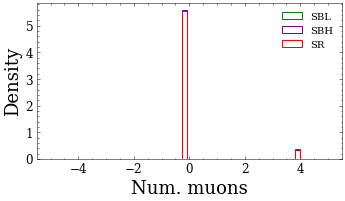

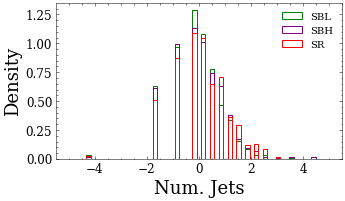

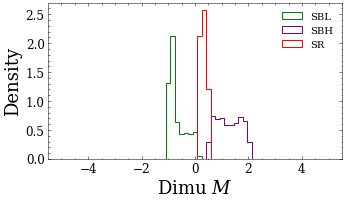

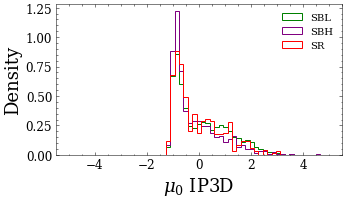

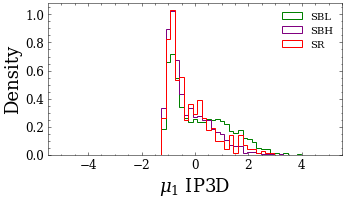

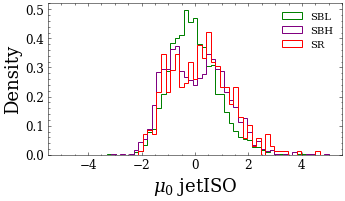

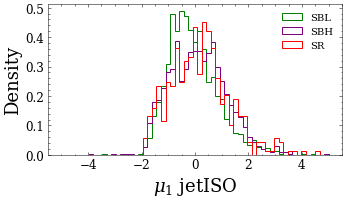

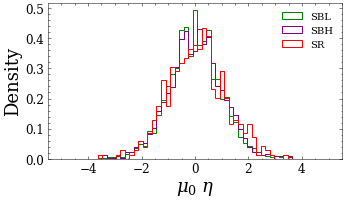

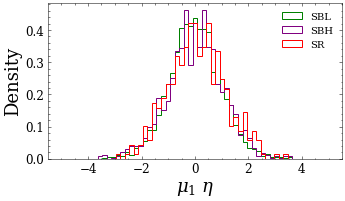

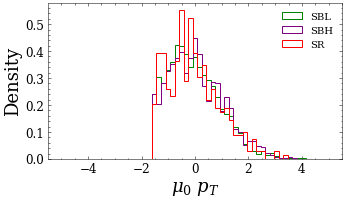

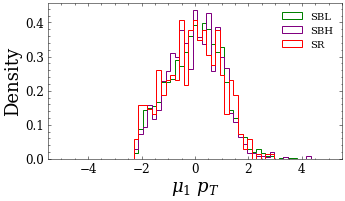

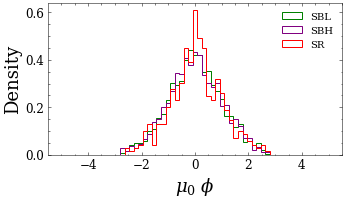

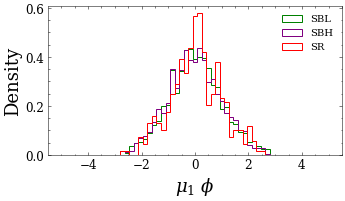

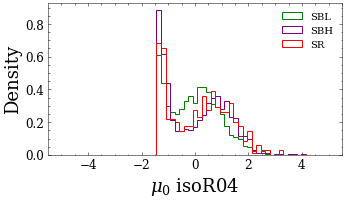

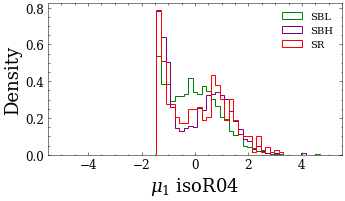

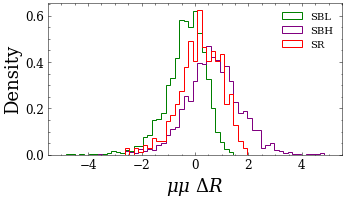

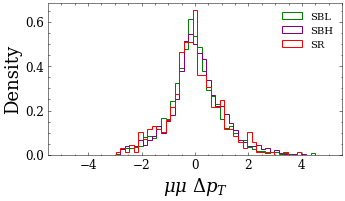

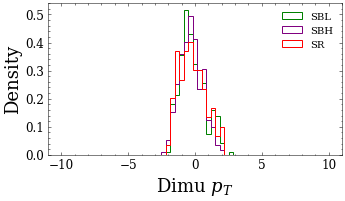

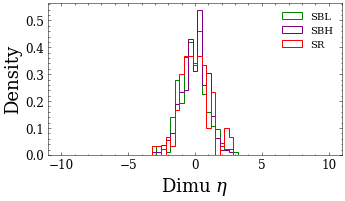

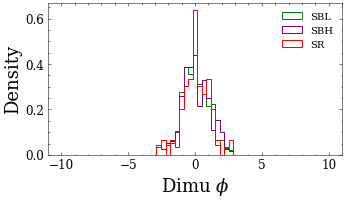

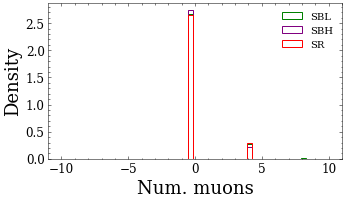

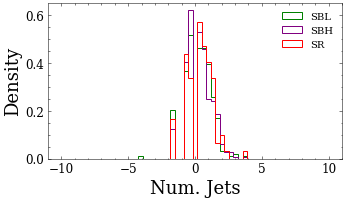

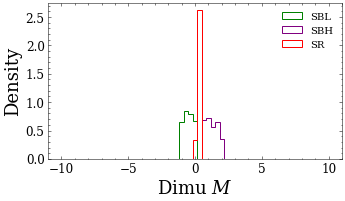

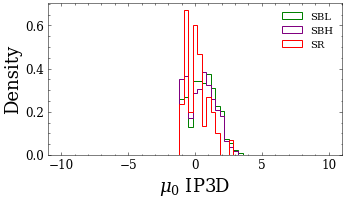

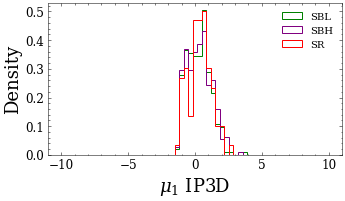

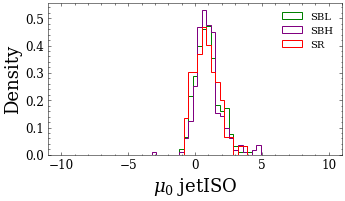

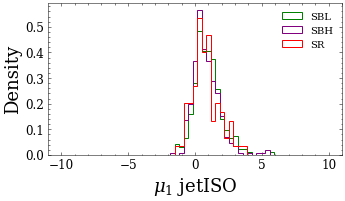

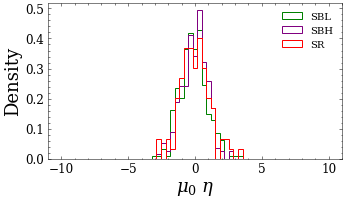

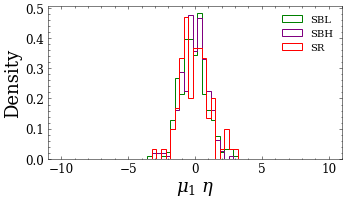

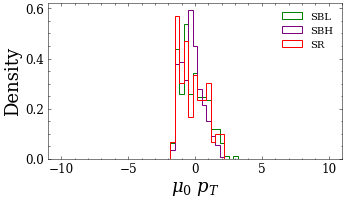

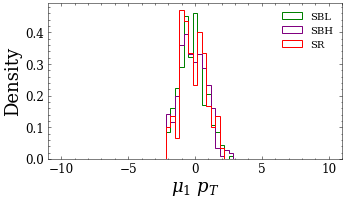

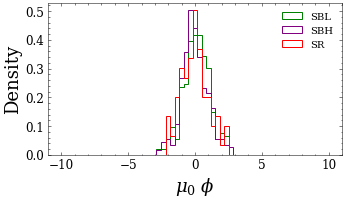

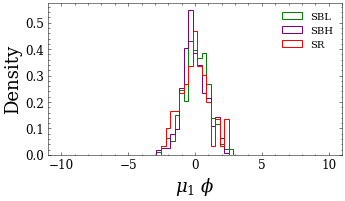

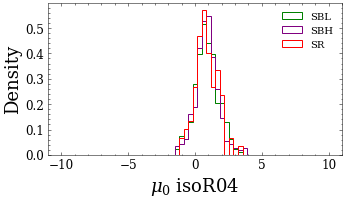

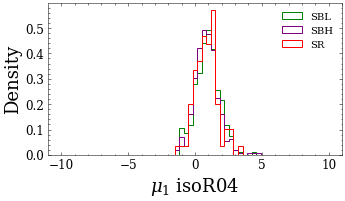

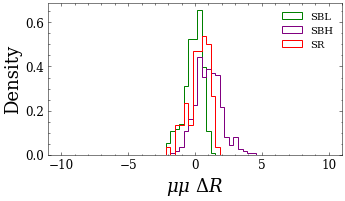

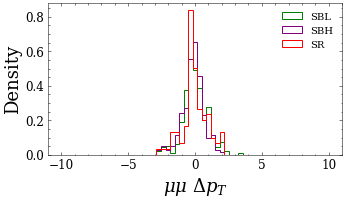


On window 114
SB bounds: 3.633998380836486, 5.567750909272213
SR bounds: 4.376776546098137, 4.622853731756954
Total events opp sign: 4132
Total events same sign: 700

On window 115
SB bounds: 3.71438605901897, 5.690915127136224
SR bounds: 4.473595220074374, 4.7251158791571495
Total events opp sign: 3409
Total events same sign: 714

On window 116
SB bounds: 3.7965519930305285, 5.816803860663604
SR bounds: 4.572555619937639, 4.829640167519985
Total events opp sign: 3200
Total events same sign: 716

On window 117
SB bounds: 3.8805355196683564, 5.945477378865344
SR bounds: 4.673705122806281, 4.936476637665695
Total events opp sign: 3211
Total events same sign: 736

On window 118
SB bounds: 3.96637684589894, 6.076997283963225
SR bounds: 4.777092153827878, 5.045676437367498
Total events opp sign: 3202
Total events same sign: 750

On window 119
SB bounds: 4.05411706810707, 6.211426540881775
SR bounds: 4.882766209362705, 5.157291845838505
Total events opp sign: 3205
Total events same sign: 75

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1


On window 130
SB bounds: 5.157291845838505, 7.901631578999195
SR bounds: 6.211426540881775, 6.560653956539837
Total events opp sign: 3350
Total events same sign: 854

On window 131
SB bounds: 5.271376298760298, 8.076423571158236
SR bounds: 6.3488295073926215, 6.705782182712455
Total events opp sign: 3368
Total events same sign: 871

On window 132
SB bounds: 5.3879844138651745, 8.255082136975826
SR bounds: 6.4892719649256545, 6.854120790376237
Total events opp sign: 3420
Total events same sign: 880

On window 133
SB bounds: 5.507172017084286, 8.437692808927869
SR bounds: 6.632821150061775, 7.005740796380151
Total events opp sign: 3450
Total events same sign: 886

On window 134
SB bounds: 5.628996169274208, 8.624343011554162
SR bounds: 6.779545786722292, 7.160714788536876
Total events opp sign: 3489
Total events same sign: 891

On window 135
SB bounds: 5.753515193534722, 8.815122103312751
SR bounds: 6.929516119070376, 7.3191169603741
Total events opp sign: 3527
Total events same sign: 8

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1


On window 148
SB bounds: 7.646510859681681, 11.715433891292138
SR bounds: 9.209434315277798, 9.727219871370128
Total events opp sign: 6793
Total events same sign: 1052

On window 149
SB bounds: 7.815659326408699, 11.974591004401411
SR bounds: 9.413156211766058, 9.942395702144706
Total events opp sign: 6824
Total events same sign: 1059

On window 150
SB bounds: 7.988549526368186, 12.239480932009775
SR bounds: 9.621384640326536, 10.162331437471849
Total events opp sign: 6825
Total events same sign: 1048

On window 151
SB bounds: 8.165264230440975, 12.510230489706762
SR bounds: 9.834219289955199, 10.387132371200163
Total events opp sign: 6841
Total events same sign: 1053

On window 152
SB bounds: 8.34588804048256, 12.786969298369565
SR bounds: 10.051762054868298, 10.616906126383482
Total events opp sign: 6843
Total events same sign: 1078

On window 153
SB bounds: 8.530507429826075, 13.069829846218799
SR bounds: 10.27411708328404, 10.85176270680521
Total events opp sign: 6854
Total events

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1

Total events opp sign: 4256
Total events same sign: 1170

On window 165
SB bounds: 11.091814549642448, 16.994080368862242
SR bounds: 13.358947552247004, 14.110032781843955
Total events opp sign: 4271
Total events same sign: 1173

On window 166
SB bounds: 11.33717657929509, 17.370006420701845
SR bounds: 13.65446083105026, 14.422160817011125
Total events opp sign: 4265
Total events same sign: 1196

On window 167
SB bounds: 11.587966262405676, 17.75424833273419
SR bounds: 13.956511159093923, 14.74119343644423
Total events opp sign: 4292
Total events same sign: 1215

On window 168
SB bounds: 11.844303664096351, 18.146990060102603
SR bounds: 14.26524314244424, 15.067283376451812
Total events opp sign: 4315
Total events same sign: 1234

On window 169
SB bounds: 12.106311505449826, 18.548419627222135
SR bounds: 14.580804585998248, 15.400586752022303
Total events opp sign: 4323
Total events same sign: 1263

On window 170
SB bounds: 12.374115222261882, 18.958729217795916
SR bounds: 14.903346564

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)
/global/u1

In [16]:
from sklearn.preprocessing import StandardScaler

bands = ["SBL", "SR", "SBH"]


for i in range(num_windows):
    
    # define SR, SB
    loc_SR_left, loc_SR_right = min(bin_definitions[i]["SR"]), max(bin_definitions[i]["SR"])
    loc_SB_left, loc_SB_right = min(bin_definitions[i]["SBL"]), max(bin_definitions[i]["SBH"])

    print(f"On window {i}")
    print(f"SB bounds: {loc_SB_left}, {loc_SB_right}")
    print(f"SR bounds: {loc_SR_left}, {loc_SR_right}")

    band_bounds = {"SBL": [loc_SB_left, loc_SR_left],
                       "SR": [loc_SR_left, loc_SR_right],
                       "SBH": [loc_SR_right, loc_SB_right],
                               }
    
    # split data into bands
    N_total_events_OS = 0
    N_total_events_SS = 0
    preproc_dicts_OS, preproc_dicts_SS = {b:{} for b in bands}, {b:{} for b in bands}

    for code in codes_list:
        for b in bands:
    
            # opp sign
            loc_pass_indices_OS = (cut_data_OS[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_OS[code]["dimu_mass"] < band_bounds[b][1])
            preproc_dicts_OS[b][code] = {}
            for feat in feature_set:
                preproc_dicts_OS[b][code][feat] = cut_data_OS[code][feat][loc_pass_indices_OS]
                
            N_total_events_OS += preproc_dicts_OS[b][code][feat].shape[0]
            
            # same sign
            loc_pass_indices_SS = (cut_data_SS[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_SS[code]["dimu_mass"] < band_bounds[b][1])
            preproc_dicts_SS[b][code] = {}
            for feat in feature_set:
                preproc_dicts_SS[b][code][feat] = cut_data_SS[code][feat][loc_pass_indices_SS]
                
            N_total_events_SS += preproc_dicts_SS[b][code][feat].shape[0]
  
    print(f"Total events opp sign: {N_total_events_OS}")
    print(f"Total events same sign: {N_total_events_SS}")
        
    
    
    sizes_dict_OS, sizes_dict_SS = {}, {}

    preprocessing_info = {}
    proccessed_data_dict_OS, proccessed_data_dict_SS  = {b:{} for b in bands}, {b:{} for b in bands}
    
    for feat in feature_set: 
        
        # train the preprocessor on the opp sign data only
        data_SB = np.hstack((preproc_dicts_OS["SBL"][code][feat], preproc_dicts_OS["SBH"][code][feat])).reshape(-1, 1)
        
        if feat == "dimu_mass": # don't logit transform
            mass_scaler = StandardScaler()
            mass_scaler = mass_scaler.fit(data_SB)
          
            with open(f"{processed_data_dir}/mass_scaler_window{i}", "wb") as ofile:
                pickle.dump(mass_scaler, ofile)
            
            for b in bands:
                proccessed_data_dict_OS[b][feat] = mass_scaler.transform(preproc_dicts_OS[b][code][feat].reshape(-1,1))
                proccessed_data_dict_SS[b][feat] = mass_scaler.transform(preproc_dicts_SS[b][code][feat].reshape(-1,1))
                sizes_dict_OS[b] = proccessed_data_dict_OS[b][feat].shape[0]
                sizes_dict_SS[b] = proccessed_data_dict_SS[b][feat].shape[0]
        
        else:   
            data_all = np.hstack((preproc_dicts_OS["SBL"][code][feat], preproc_dicts_OS["SBH"][code][feat], preproc_dicts_OS["SR"][code][feat])).reshape(-1, 1)
            all_min = np.min(data_all)
            all_max = np.max(data_all)
            # logit transform the features   
        
            transformed_feats = logit_transform(data_SB, all_min, all_max)
            # subtract off mean, std of the training set
            mean_to_sub = np.mean(transformed_feats)
            std_to_sub = np.std(transformed_feats)
            
            preprocessing_info[feat] = {"mean":mean_to_sub, "std":std_to_sub, "min":all_min, "max":all_max}
            
            for b in bands:
                proccessed_data_dict_OS[b][feat] = (logit_transform(preproc_dicts_OS[b][code][feat], all_min, all_max) - mean_to_sub)/std_to_sub
                proccessed_data_dict_SS[b][feat] = (logit_transform(preproc_dicts_SS[b][code][feat], all_min, all_max) - mean_to_sub)/std_to_sub
    
    with open(f"{processed_data_dir}/preprocessing_info_window{i}", "wb") as ofile:
                pickle.dump(preprocessing_info, ofile)
    

    with open(f"{processed_data_dir}/window{i}_OS_test_band_data", "wb") as ofile:
        pickle.dump(proccessed_data_dict_OS, ofile)

    
    with open(f"{processed_data_dir}/window{i}_SS_test_band_data", "wb") as ofile:
        pickle.dump(proccessed_data_dict_SS, ofile)

    if i == 113:

      


        hist_all_features_dict([proccessed_data_dict_OS["SBL"], proccessed_data_dict_OS["SBH"], proccessed_data_dict_OS["SR"]], 
                           ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=5, image_path=None, yscale_log=False, nice_labels=True)
    
    
        hist_all_features_dict([proccessed_data_dict_SS["SBL"], proccessed_data_dict_SS["SBH"], proccessed_data_dict_SS["SR"]], 
                           ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=10, image_path=None, yscale_log=False, nice_labels=True)
    
    

    print()


## Visualize


Create a batch script for flow training


In [18]:
feature_sets = workflow["feature_sets"]

num_windows = len(bin_definitions.keys())
    
batches_to_run = ["mix_2"]
seeds = [1,2,3,4,5]

with open("batch_lowmass_scan_05.sh", "w") as ofile:
    
    ofile.write("#!/bin/sh \n\n")
    ofile.write("#SBATCH -N 1\n")
    ofile.write("#SBATCH -C gpu\n")
    ofile.write("#SBATCH -G 1\n")
    ofile.write("#SBATCH -q regular\n")
    ofile.write("#SBATCH --job-name=lowmass_scan\n")
    ofile.write("#SBATCH --mail-user=rmastand@berkeley.edu\n")
    ofile.write("#SBATCH --mail-type=ALL\n")
    ofile.write("#SBATCH -t 1:00:00\n")
    ofile.write("#SBATCH -A m3246\n")
    ofile.write(f"#SBATCH --array=0-{2*num_windows-1}\n\n")
    ofile.write(f"declare -a commands=(\n")

    i = 0

    for fs in batches_to_run:
        for window_index in range(num_windows): 
            for seed in seeds:
    
                loc_command = '[{i}]="python 05_train_cathode.py -workflow workflow_scan -bootstrap window{window_index} -fid {feature_set} -feats {feature_list},dimu_mass -seed {seed} -premade_bins -win {window_index} -fit quintic"'.format(feature_set=fs,feature_list = ",".join(feature_sets[fs]), window_index = window_index, i = i, seed=seed )
                #oc_command = 'python 05_trueCATHODE.py -fid {feature_set} -f {feature_list},dimu_mass -pid lowmass_{window_index}_{jet_id} -c CATHODE_8 -seed 1 -did lowmass_scan -premade_bins'.format(feature_set=fs,feature_list = ",".join(feature_sets[fs]), window_index = window_index, i = i, jet_id = jet_id )
    
                ofile.write(loc_command)
                ofile.write("\n")
                loc_command = '[{i}]="python 05_train_cathode.py -workflow workflow_scan -bootstrap window{window_index} -fid {feature_set} -feats {feature_list},dimu_mass -seed {seed} -premade_bins -win {window_index} -fit quintic -train_samesign"'.format(feature_set=fs,feature_list = ",".join(feature_sets[fs]), window_index = window_index, i = 2*i+1, seed=seed )
                ofile.write(loc_command)
                ofile.write("\n")
                i += 1

    ofile.write(f")\n")
    ofile.write(f"srun ${{commands[$SLURM_ARRAY_TASK_ID]}}")



In [19]:
feature_sets = workflow["feature_sets"]

num_windows = len(bin_definitions.keys())
    
batches_to_run = ["mix_2"]

#with open("batch_lowmass_scan_06.sh", "w") as ofile:

for fs in batches_to_run:
    for window_index in range(num_windows): 

        loc_command = f'python 06_eval_cathode.py -workflow workflow_scan -bootstrap window{window_index} -fit quintic -fid {fs} -seeds 1,2,3,4,5'
        print(loc_command)
        loc_command += " -train_samesign"
        print(loc_command)

python 06_eval_cathode.py -workflow workflow_scan -bootstrap window0 -fit quintic -fid mix_2 -seeds 1,2,3,4,5
python 06_eval_cathode.py -workflow workflow_scan -bootstrap window0 -fit quintic -fid mix_2 -seeds 1,2,3,4,5 -train_samesign
python 06_eval_cathode.py -workflow workflow_scan -bootstrap window1 -fit quintic -fid mix_2 -seeds 1,2,3,4,5
python 06_eval_cathode.py -workflow workflow_scan -bootstrap window1 -fit quintic -fid mix_2 -seeds 1,2,3,4,5 -train_samesign
python 06_eval_cathode.py -workflow workflow_scan -bootstrap window2 -fit quintic -fid mix_2 -seeds 1,2,3,4,5
python 06_eval_cathode.py -workflow workflow_scan -bootstrap window2 -fit quintic -fid mix_2 -seeds 1,2,3,4,5 -train_samesign
python 06_eval_cathode.py -workflow workflow_scan -bootstrap window3 -fit quintic -fid mix_2 -seeds 1,2,3,4,5
python 06_eval_cathode.py -workflow workflow_scan -bootstrap window3 -fit quintic -fid mix_2 -seeds 1,2,3,4,5 -train_samesign
python 06_eval_cathode.py -workflow workflow_scan -boots

In [ ]:
n_ensemble = 20
n_bootstrap = 1

with open("batch_lowmass_scan_07.sh", "w") as ofile:
    

    for fs in batches_to_run:
        for window_index in range(num_windows): 

            loc_command = f'python 07_bump_hunt_boostrap.py -f {fs} -p {window_index} -ne {n_ensemble} -nb {n_bootstrap} -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            ofile.write(loc_command+"\n")
            loc_command = f'python 07_bump_hunt_boostrap.py -f {fs} -p {window_index} -train_samesign -ne {n_ensemble} -nb {n_bootstrap} -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            #ofile.write(loc_command+"\n")
            

    ofile.write(f"\n")

